In [4]:
fname = 'ASTR19_S22_group_project_data.txt'
#open the file with read mode
f = open(fname,'r')

#print the name of the file
print(f.name)
#read the data as a string
test_data = f.read()
#print the info from the file
print(test_data)

ASTR19_S22_group_project_data.txt
#Column A: Day of the year
#Column B: Time in hours:minutes
#Column B: Tide Height in feet
 1  8:07  6.57
 1 15:37 -0.39
 2  8:55  5.38
 2 16:25 -1.74
 3  9:45  5.26
 3 17:14 -1.36
 4 10:35  4.13
 4 18:00 -1.15
 5 11:28  3.48
 5 18:46 -1.61
 6 12:22  2.62
 6 19:31  0.05
 7 13:24  1.83
 7 20:16  1.01
 8  3:22  3.57
 8 21:01  0.73
 9  4:07  4.54
 9 21:46  2.17
10  4:50  3.76
10 11:58  2.88
11  5:31  3.90
11 12:56  1.92
12  6:08  4.73
12 13:45  1.74
13  6:47  5.66
13 14:25  0.79
14  7:22  5.33
14 15:00 -0.04
15  7:59  5.23
15 15:34 -1.12
16  8:34  6.67
16 16:08 -0.61
17  9:10  4.74
17 16:41 -0.93
18  9:45  4.69
18 17:12 -1.29
19 10:21  4.20
19 17:45  0.22
20 10:57  3.68
20 18:15  0.26
21 11:38  2.47
21 18:48  0.36
22 12:25  2.59
22 19:20  0.99
23  2:22  4.10
23 19:52  1.87
24  2:58  3.17
24 20:30  1.60
25  3:37  3.71
25 10:44  3.10
26  4:23  4.04
26 11:55  2.49
27  5:15  4.07
27 12:57  2.18
28  6:09  5.93
28 13:50  0.70
29  7:05  6.89
29 14:39  0.21
30  7

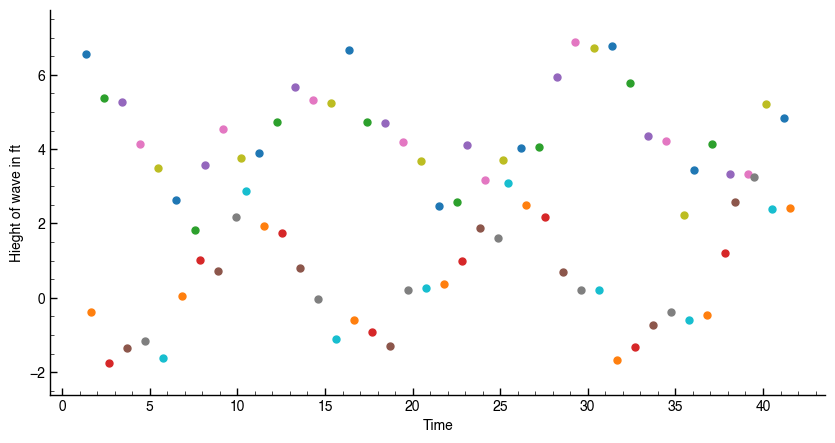

In [22]:
import numpy as np
import matplotlib.pyplot as plt


    
#define the filename
fname = 'ASTR19_S22_group_project_data.txt'
#open the file with numpy loadtxt



test_data = np.loadtxt(fname, dtype={'names': ('day', 'time', 'height'),'formats': ('i4', 'S5', 'f4')})
#print the info from the file
#print(test_data)

plt.style.use("./astr19_matplotlib_defaults.txt")
f=plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time')
plt.ylabel('Hieght of wave in ft')



for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    #print ("("+ str(totalMinutes) +"," + str(height)+")")
    x= timeindays
    y=height
    plt.scatter(x,y)
